In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech import Poincare
from matplotlib.lines import Line2D
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

# Fix P1 = 1, and P3 close to 2, then sampling P2 from 4/3 to 3/2 puts it between the 4/3 and 3/2 with both planets symmetrically

Don't want artifacts from 2:1 between P1 and P3, so place it at 2.0328, between the 61:30 and 63:31. The widths of the 1st order MMRs are deltaP ~ 0.01 for these mass ratios and eccentricities, so this is far enough away

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def eq_mass_mixed_eigen(seed, P12, P3, etilde, mu):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    reb_add_from_elements(m=mu*10, elements={'P':P3}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['R'] @ secsim['M'] @ secsim['R'].T
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    A = [1,0,0]
    v0 = T @ A
    v0 /= np.linalg.norm(v0)
    A = [0,1,0]
    v1 = T @ A
    v1 /= np.linalg.norm(v1)
    v = -2/v0[0]*v0 + 1/v1[0]*v1 # init such that A0 contributes -2 to e-, and A1 contributes +1
    zstar = secsim['S'] @ secsim['R'].T @ v
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu*10, elements={'P':P3,'e':abs(zstar[2])*e, 'pomega':np.arccos(np.sign(zstar[2])), 'M':np.random.random()*2*np.pi}, sim=sim)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    minTperi = ps[1].P*(1-ps[1].e)**1.5/(1+ps[1].e)**0.5
    sim.dt = minTperi/20
    
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_eigen(params):
    seed, P12, P3, etilde, mu, tmax = params
    sim = eq_mass_mixed_eigen(seed, P12, P3, etilde, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = 3*Tsec[1]
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

In [3]:
seed, P12, P3, etilde, mu, tmax = 0, 1/1.4, 3.2, 0.2, 1e-4, 0
sim = eq_mass_mixed_eigen(seed, P12, P3, etilde, mu)

lsys = LaplaceLagrangeSystem.from_Simulation(sim)
eigvals = lsys.eccentricity_eigenvalues()
Tsec = np.abs(2 * np.pi / eigvals)
Tsec

array([  2928.11716712,   6076.51212966, 208072.49466133])

In [4]:
def get_pool_params(xlist, ylist, P3, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, P3, y, mu, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
h = np.ones(11)*0.4
h[1] = 0.535
h[2] = 0.426
h[3] = 0.420
h[4] = 0.454
h[5] = 0.519
h[6] = 0.613
h[7] = 0.742
h[8] = 0.914
h[9] = 1.143
h[10] = 1.445

In [ ]:
mu=1e-4
etildemax=0.5
P3 = 3.2
tmax = None

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [ ]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, tmax=2e4)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('mixedeigenmode.npy', results)

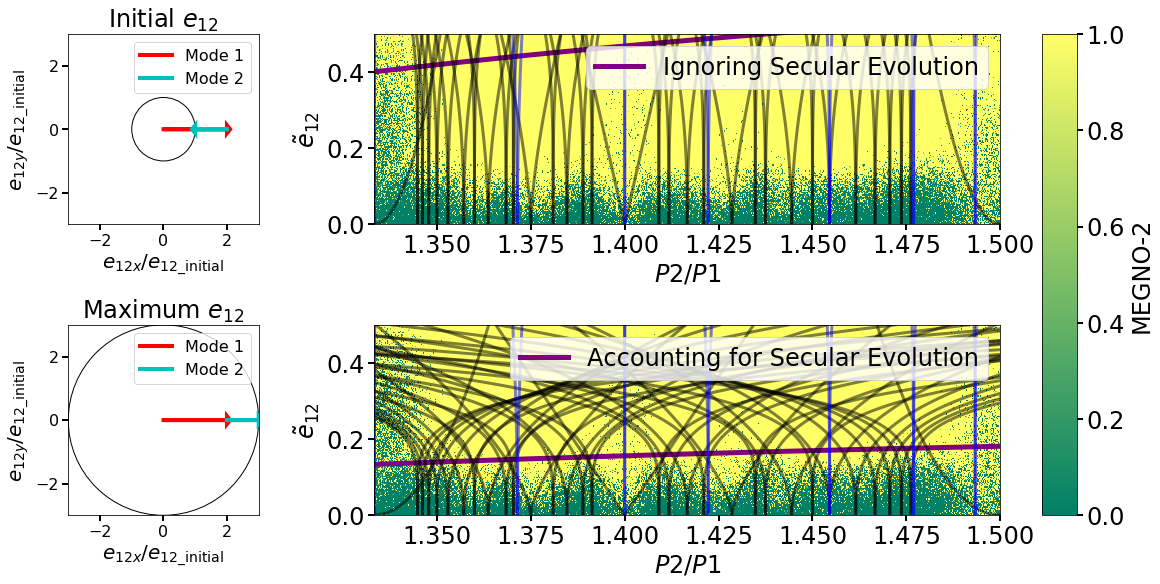

In [5]:
mu=1e-4
etildemax=0.5
P3 = 3.2

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 160
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

fig = plt.figure(figsize=(16,8), constrained_layout=True)
gs = fig.add_gridspec(2, 15)
ax = fig.add_subplot(gs[0, 4:-1])

res = np.load('mixedeigenmode.npy')
megno = res

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)

ax.set_xlabel("Period Ratio")
ax.set_ylabel(r'$\tilde{e}_{\rm{12}}}$', fontsize=24)

kmax=10
jmax=100

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])

#fig.subplots_adjust(right=0.9, wspace=0.05)
#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_ax = fig.add_subplot(gs[:, -1])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)
cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)

e1 = 2
e2 = 1
pomega1 = 0
pomega2 = np.pi

e1x = e1*np.cos(pomega1)
e1y = e1*np.sin(pomega1)
e2x = e2*np.cos(pomega2)
e2y = e2*np.sin(pomega2)
f = np.sqrt((e1x+e2x)**2 + (e1y+e2y)**2)

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='purple', lw=5, label='Ignoring Secular Evolution')
ax.legend(loc='upper right', fontsize=24)

for k in range(1,kmax+1):
    for j in range(2*k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            #ax.text(P21-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), fontsize=20)
            es = np.linspace(0, etildemax, 100)
            dPs = (j/(j-k))**(2/3)*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*(es*f)**(k/2)
            ax.plot(P21+dPs, es, 'k', alpha=0.5)
            ax.plot(P21-dPs, es, 'k', alpha=0.5)

for k in range(1,kmax+1):
    for j in range(k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P23 = (j-k)/j # P2/P3
        alpha = P23**(2/3)
        P2 = P23*P3
        ec23 = 1-alpha
        ec21 = 1-P2**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P23*P3 > 1/P12s.max()-0.01 and P23*P3 < 1/P12s.min()+0.01:
            e12s = np.linspace(0, etildemax, 100)
            e23s = e12s*ec21/ec23
            dPs = (j-k)/j*P3*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*e23s**(k/2)
            ax.plot(P2+dPs, es, 'b', alpha=0.5)
            ax.plot(P2-dPs, es, 'b', alpha=0.5)
            
ax = fig.add_subplot(gs[0, :4])
ax.set_title(r'Initial $e_{12}$')
ax.set_aspect('equal')
ax.set_xlabel(r'$e_{12x}/e_{12\_\rm{initial}}$')
ax.set_ylabel(r'$e_{12y}/e_{12\_\rm{initial}}$')
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
custom_lines = [Line2D([0], [0], color='r', lw=4), Line2D([0], [0], color='c', lw=4)]
ax.legend(custom_lines, ['Mode 1', 'Mode 2'])

ax.arrow(0, 0, e1x, e1y, head_width=0.25, linewidth=4, head_length=0.1, fc='r', ec='r', label='Mode 1')
ax.arrow(e1x, e1y, e2x, e2y, head_width=0.25, linewidth=4, head_length=0.1, fc='c', ec='c', label='Mode 2')
circle = plt.Circle((0, 0), f, color='k', fill=False)
ax.add_patch(circle)

ax = fig.add_subplot(gs[1, 4:-1])
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)

ax.set_xlabel("Period Ratio")
ax.set_ylabel(r'$\tilde{e}_{\rm{12}}}$', fontsize=24)

kmax=10
jmax=100

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$P2/P1$", fontsize=24)

e1 = 2
e2 = 1
pomega1 = 0
pomega2 = 0

e1x = e1*np.cos(pomega1)
e1y = e1*np.sin(pomega1)
e2x = e2*np.cos(pomega2)
e2y = e2*np.sin(pomega2)
f = np.sqrt((e1x+e2x)**2 + (e1y+e2y)**2)

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3))/3, color='purple', lw=5, label='Accounting for Secular Evolution')
ax.legend(loc='upper right', fontsize=24)

for k in range(1,kmax+1):
    for j in range(2*k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            #ax.text(P21-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), fontsize=20)
            es = np.linspace(0, etildemax, 100)
            dPs = (j/(j-k))**(2/3)*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*(es*f)**(k/2)
            ax.plot(P21+dPs, es, 'k', alpha=0.5)
            ax.plot(P21-dPs, es, 'k', alpha=0.5)

for k in range(1,kmax+1):
    for j in range(k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P23 = (j-k)/j # P2/P3
        alpha = P23**(2/3)
        P2 = P23*P3
        ec23 = 1-alpha
        ec21 = 1-P2**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P23*P3 > 1/P12s.max()-0.01 and P23*P3 < 1/P12s.min()+0.01:
            e12s = np.linspace(0, etildemax, 100)
            e23s = e12s*ec21/ec23
            dPs = (j-k)/j*P3*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*e23s**(k/2)
            ax.plot(P2+dPs, es, 'b', alpha=0.5)
            ax.plot(P2-dPs, es, 'b', alpha=0.5)
            
ax = fig.add_subplot(gs[1, :4])
ax.set_title(r'Maximum $e_{12}$')
ax.set_aspect('equal')
ax.set_xlabel(r'$e_{12x}/e_{12\_\rm{initial}}$')
ax.set_ylabel(r'$e_{12y}/e_{12\_\rm{initial}}$')
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
custom_lines = [Line2D([0], [0], color='r', lw=4), Line2D([0], [0], color='c', lw=4)]
ax.legend(custom_lines, ['Mode 1', 'Mode 2'])

ax.arrow(0, 0, e1x, e1y, head_width=0.25, linewidth=4, head_length=0.1, fc='r', ec='r', label='Mode 1')
ax.arrow(e1x, e1y, e2x, e2y, head_width=0.25, linewidth=4, head_length=0.1, fc='c', ec='c', label='Mode 2')
circle = plt.Circle((0, 0), f, color='k', fill=False)
ax.add_patch(circle)
fig.savefig('mixedeigenmode.pdf')